# Model Comparison Under Asymmetric Costs (CWSL vs RMSE / wMAPE)

This example shows how **Cost-Weighted Service Loss (CWSL)** can be used as a
*model selection* criterion when you have multiple candidate forecasts.

We will:

- Create a short time series of demand.
- Define several simple forecast models:
  - a slightly under-leaning model,
  - a slightly over-leaning model,
  - a "noisy but unbiased" model,
  - and a naive reference.
- Compare models using:
  - **RMSE** and **wMAPE** (symmetric error metrics),
  - **CWSL** with an asymmetric cost ratio R = cu / co,
  - **CWSL sensitivity** across multiple R values.
- Use these results to decide which model is best **when shortfalls are more
  expensive than overbuilds**.

The goal is to show how CWSL can change which model you choose, and how you
can justify that choice based on operational cost instead of just symmetric
error.

In [1]:
import numpy as np
import pandas as pd

from cwsl import (
    cwsl,
    rmse,
    wmape,
    cwsl_sensitivity,
)

np.set_printoptions(suppress=True, floatmode="fixed")

# Synthetic demand: peak + off-peak pattern repeated twice
y_true_one = np.array([10, 12, 15, 20, 25, 22, 18, 14, 10], dtype=float)
y_true = np.tile(y_true_one, 2)  # repeat pattern

# Model A: UNDER-leaning (systematically a bit low, especially at peak)
# - Slightly under-forecasts across the board
# - Larger shortfalls at higher demand
y_pred_under = np.where(
    y_true >= 20, y_true - 3,
    np.where(y_true >= 15, y_true - 2, y_true - 1)
)

# Model B: OVER-leaning (systematically a bit high, especially at peak)
# - Slightly over-forecasts across the board
# - Larger overbuild at higher demand
y_pred_over = np.where(
    y_true >= 20, y_true + 3,
    np.where(y_true >= 15, y_true + 2, y_true + 1)
)

# Model C: naive lag model (baseline reference)
y_pred_naive = np.roll(y_true, 1)
y_pred_naive[0] = y_true[0]

df = pd.DataFrame({
    "y_true": y_true,
    "y_pred_under": y_pred_under,
    "y_pred_over": y_pred_over,
    "y_pred_naive": y_pred_naive,
})
df

,y_true,y_pred_under,y_pred_over,y_pred_naive
0,10.0,9.0,11.0,10.0
1,12.0,11.0,13.0,10.0
2,15.0,13.0,17.0,12.0
3,20.0,17.0,23.0,15.0
4,25.0,22.0,28.0,20.0
5,22.0,19.0,25.0,25.0
6,18.0,16.0,20.0,22.0
7,14.0,13.0,15.0,18.0
8,10.0,9.0,11.0,14.0
9,10.0,9.0,11.0,10.0


## Comparing Models: RMSE, wMAPE, and CWSL (R = 2)

Now we compare our three models:

- **under_lean** – systematically a bit low, especially at the peak  
- **over_lean** – systematically a bit high, especially at the peak  
- **naive** – simple lag model as a baseline  

We’ll compute:

- **RMSE** – symmetric squared error  
- **wMAPE** – demand-normalized absolute error  
- **CWSL (R = 2)** – asymmetric cost, where shortfalls are 2× worse than overbuilds  

The goal is to see:

- how symmetric metrics treat *under* vs *over* models, and  
- how CWSL changes the ranking when shortfalls are more expensive.

In [2]:
models = {
    "under_lean": y_pred_under,
    "over_lean": y_pred_over,
    "naive": y_pred_naive,
}

rows = []
R = 2.0
co = 1.0
cu = R * co

for name, y_pred in models.items():
    rows.append(
        {
            "model": name,
            "RMSE": rmse(y_true, y_pred),
            "wMAPE": wmape(y_true, y_pred),
            "CWSL (R=2)": cwsl(y_true, y_pred, cu=cu, co=co),
        }
    )

metrics_df = pd.DataFrame(rows).set_index("model")
metrics_df

,RMSE,wMAPE,CWSL (R=2)
model,,,
under_lean,2.081666,0.116438,0.232877
over_lean,2.081666,0.116438,0.116438
naive,3.651484,0.205479,0.308219


## Cost Sensitivity Analysis Across R

CWSL depends on the cost ratio **R = cu / co**.

Here we evaluate each model across a range of R values to understand:

- Which model is *robust* across cost assumptions  
- How sensitive each model is to shortfall penalties  
- Whether small changes in R can flip the preferred model  

A good model should remain competitive even if R shifts between
reasonable values (e.g., 0.5 → 3.0).

In [3]:
R_values = [0.5, 1.0, 2.0, 3.0]

sensitivity_rows = []

for R in R_values:
    cu = R
    co = 1.0
    row = {"R": R}
    for name, pred in models.items():
        row[f"CWSL_{name}"] = cwsl(y_true, pred, cu=cu, co=co)
    sensitivity_rows.append(row)

sensitivity_df = pd.DataFrame(sensitivity_rows)
sensitivity_df

,R,CWSL_under_lean,CWSL_over_lean,CWSL_naive
0,0.5,0.058219,0.116438,0.154110
1,1.0,0.116438,0.116438,0.205479
2,2.0,0.232877,0.116438,0.308219
3,3.0,0.349315,0.116438,0.410959


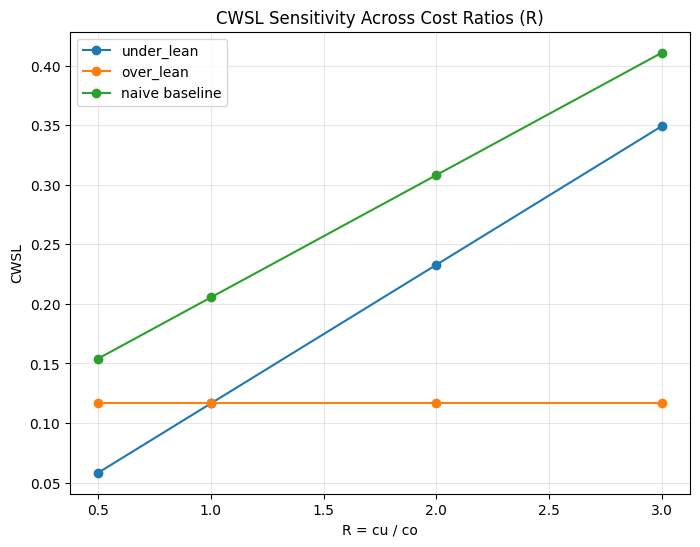

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.plot(sensitivity_df["R"], sensitivity_df["CWSL_under_lean"], "-o", label="under_lean")
plt.plot(sensitivity_df["R"], sensitivity_df["CWSL_over_lean"], "-o", label="over_lean")
plt.plot(sensitivity_df["R"], sensitivity_df["CWSL_naive"], "-o", label="naive baseline")

plt.xlabel("R = cu / co")
plt.ylabel("CWSL")
plt.title("CWSL Sensitivity Across Cost Ratios (R)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Conclusion: What the Sensitivity Analysis Reveals

This experiment highlights a fundamental insight that symmetric error metrics cannot show:

**Different forecast bias profiles react very differently when the operational cost of under-forecasting increases.**

Key findings:

- **The over-lean model is stable across all R values**  
  Because it rarely shortfalls, increasing cu (shortfall cost) does not meaningfully affect its CWSL.  
  This stability is *invisible* under RMSE and wMAPE, but becomes obvious under CWSL.

- **The under-lean model becomes increasingly expensive as R increases**  
  Its CWSL rises linearly with R because it chronically shortfalls.  
  Symmetric metrics cannot reveal this operational fragility.

- **The naïve model performs the worst at every R value**  
  It combines shortfalls and overbuilds in a way that makes it highly sensitive to asymmetric cost structures.  
  As R increases, it becomes dramatically less viable.

### Why this matters  
In real operations, especially in environments with peak-driven demand (QSR, retail, logistics, manufacturing):

- A model’s **bias direction** is just as important as its magnitude.  
- The cost of being “too low” is often **far higher** than being “too high.”  
- CWSL exposes this reality directly, while RMSE and wMAPE treat all errors as equivalent.

This example demonstrates that **CWSL does not simply re-rank models** —  
it **redefines what “good” means** under operational constraints.

In practice, this changes model selection, model tuning, and the entire philosophy of forecast evaluation.